In [1]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn import datasets
from sklearn.metrics.pairwise import euclidean_distances
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from typing import Tuple, List
from sklearn.preprocessing import MinMaxScaler
import warnings
import scipy
import numba as nb
import requests
import sys

sys.path.insert(1, "./umap")
warnings.filterwarnings('always')

def visualize(x, y, axis):
    colors = cm.rainbow(np.linspace(0, 1, max(y) - min(y) + 1))
    for sample_index in range(len(x)):
        sample = x[sample_index]
        label = y[sample_index]
        axis.scatter(sample[0], sample[1], color=colors[label], s=10)

def visualize_loss(function):
    X = np.arange(0.1, 0.9, 0.1)
    Y = np.arange(0.1, 0.9, 0.1)
    X = np.exp(-X ** 2) + 1e-8
    Y = 1 / ((1 + Y ** 2) + 1e-8) + 1e-8
    X, Y = np.meshgrid(X, Y)
    Z = function(X, Y)
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.view_init(azim=30)
    surf = ax.plot_surface(X, Y, Z, cmap=cm.viridis)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

def evaluate_visualizations(
    min_neighbors: int,
    max_neighbors: int,
    low_dimension_factory,
    show_cross_entropy: bool = False,
    one_run: bool = False):
    def evaluate_umap(axis, neighbors: List[int]):
        print(f'Running UMAP for neighbors count: {neighbors}')
        axis.set_title(f'Neighbors: {neighbors}')
        response = low_dimension_factory(neighbors)
        visualize(response[0], labels, axis)
        y = MinMaxScaler().fit_transform(response[0])
        return response
    figure, axes = plt.subplots(2, 2, figsize=(12, 12))
    evaluate_umap(axes[0, 0], [min_neighbors])
    if one_run:
        return []
    evaluate_umap(axes[0, 1], [max_neighbors])
    response = evaluate_umap(axes[1, 0], [min_neighbors, max_neighbors])
    if len(response) > 1:
        axes[1, 1].plot(response[1], label="Weighted Cross Entropy")
        axes[1, 1].legend()
    if len(response) > 2 and show_cross_entropy:
        axes[1, 1].plot(response[2], label="Cross Entropy")
        axes[1, 1].legend()
    return response[1] if len(response) > 1 else None

dataset = datasets.make_blobs(n_samples=1500, random_state=8)
labels = dataset[1] #[0:200]
digits = dataset[0] #[0:200]
digits.shape

(1500, 2)

## Parameters

In [2]:
distances = euclidean_distances(digits, digits)
MIN_NEIGHBORS = 5
MAX_NEIGHBORS = 10
FULL_MIN_NEIGHBORS = int(len(digits) / 2)
FULL_MAX_NEIGHBORS = len(digits)
MIN_DIST = 1.0
ITERATION_LIMIT = 150

## L1. Fuzzy Cross Entropy

/data/umap/umap/__init__.py:9: ImportWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn(


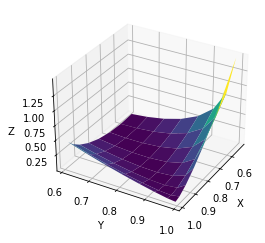

In [3]:
from algorithm import umap, GradientOptimizer, Adam, CrossEntropyLoss
visualize_loss(lambda P, Q: P * np.log(P / Q) + (1 - P) * np.log((1 - P) / (1 - Q)))

Running UMAP for neighbors count: [10]


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[1]: loss 793926.5886757784
[50]: loss 37959.19608100914
[100]: loss 30633.86498342783
[150]: loss 26090.255958672962
Running UMAP for neighbors count: [1500]
[1]: loss 1384899.881486248
[50]: loss 524399.862881384
[100]: loss 493454.4556440755
[150]: loss 493264.69108933356
Running UMAP for neighbors count: [10, 1500]
[1]: loss 2515531.019442978
[50]: loss 674154.4264241396
[100]: loss 643281.713900104
[150]: loss 642996.1165322195
CPU times: user 9min 34s, sys: 18.4 s, total: 9min 53s
Wall time: 3min 55s


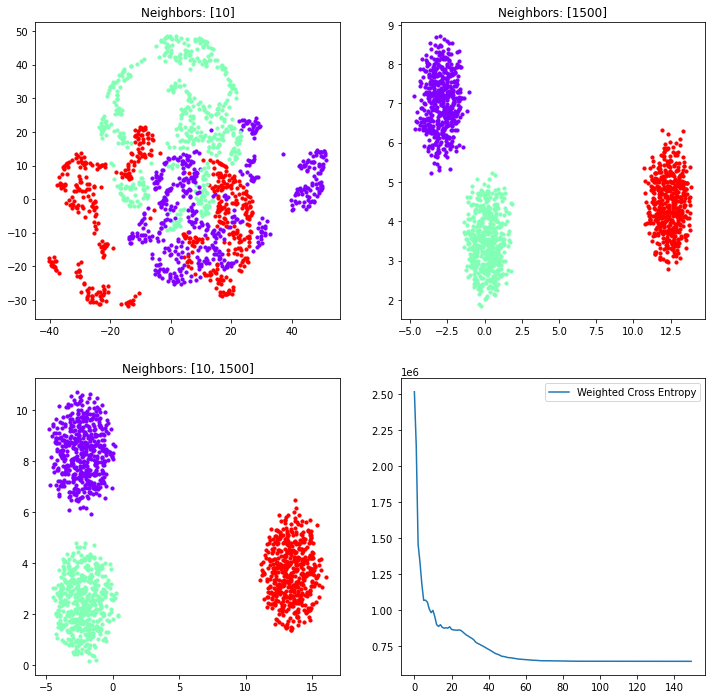

In [4]:
%%time
cel = evaluate_visualizations(
    min_neighbors=MAX_NEIGHBORS,
    max_neighbors=FULL_MAX_NEIGHBORS,
    low_dimension_factory=lambda neighbors: umap(
        pairwise_distances=distances,
        neighbor_counts=neighbors,
        n_components=2,
        min_dist=MIN_DIST,
        optimizer=GradientOptimizer(
            optimizer=Adam(n=len(digits), iterations=ITERATION_LIMIT),
            loss=CrossEntropyLoss())))

## L2. Symmetric Fuzzy Cross Entropy

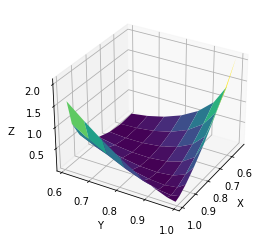

In [5]:
from algorithm import SymmetricLoss
visualize_loss(lambda P, Q: (P - Q) * np.log((P * (1 - Q)) / (Q * (1 - P))))

Running UMAP for neighbors count: [10]
[1]: loss 6202597.1799788475
[50]: loss 115166.15557728238
[100]: loss 98294.30332554376
[150]: loss 90537.1961547286
Running UMAP for neighbors count: [1500]
[1]: loss 1180387.318525123
[50]: loss 91935.52963413758
[100]: loss 54812.13897598139
[150]: loss 54578.161936535515
Running UMAP for neighbors count: [10, 1500]
[1]: loss 2602791.26616886
[50]: loss 256745.60675734666
[100]: loss 221470.15283842047
[150]: loss 221294.81571006103
CPU times: user 8min 58s, sys: 26.8 s, total: 9min 25s
Wall time: 3min 39s


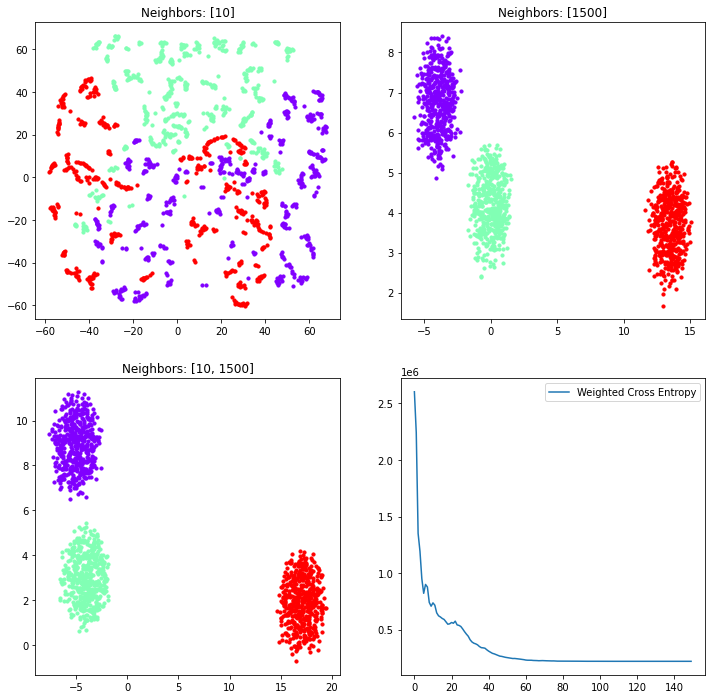

In [6]:
%%time
sl = evaluate_visualizations(
    min_neighbors=MAX_NEIGHBORS,
    max_neighbors=FULL_MAX_NEIGHBORS,
    low_dimension_factory=lambda neighbors: umap(
        pairwise_distances=distances,
        neighbor_counts=neighbors,
        n_components=2,
        min_dist=MIN_DIST,
        optimizer=GradientOptimizer(
            optimizer=Adam(n=len(digits), iterations=ITERATION_LIMIT),
            loss=SymmetricLoss())))

## L3. Intuitionistic Fuzzy Cross Entropy

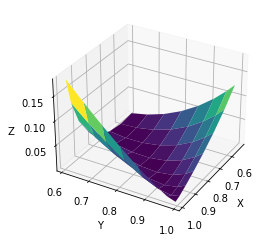

In [7]:
from algorithm import IntuitionisticLoss
visualize_loss(lambda P, Q: P * np.log(P / (0.5*P + 0.5*Q)) + (1 - P)*np.log((1 - P) / (1 - 0.5*(P + Q))))

Running UMAP for neighbors count: [10]
[1]: loss 112046.27704068334
[50]: loss 8392.427506521402
[100]: loss 7988.822484392726
[150]: loss 7837.834011550876
Running UMAP for neighbors count: [1500]
[1]: loss 488874.828300637
[50]: loss 483669.062854267
[100]: loss 464355.7791857343
[150]: loss 463394.6621180992
Running UMAP for neighbors count: [10, 1500]
[1]: loss 562328.2006545806
[50]: loss 522870.0269058344
[100]: loss 511288.7047689869
[150]: loss 510221.39432866586
CPU times: user 9min 8s, sys: 25.2 s, total: 9min 33s
Wall time: 5min 11s


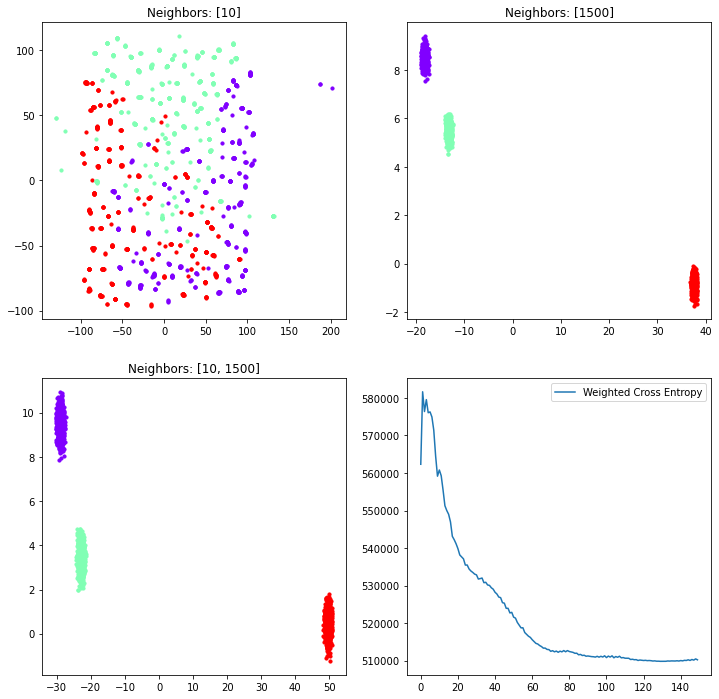

In [8]:
%%time
il = evaluate_visualizations(
    min_neighbors=MAX_NEIGHBORS,
    max_neighbors=FULL_MAX_NEIGHBORS,
    low_dimension_factory=lambda neighbors: umap(
        pairwise_distances=distances,
        neighbor_counts=neighbors,
        n_components=2,
        min_dist=0.1 * MIN_DIST,
        optimizer=GradientOptimizer(
            optimizer=Adam(n=len(digits), iterations=ITERATION_LIMIT),
            loss=IntuitionisticLoss())))

## L4. Weighted Fuzzy Cross Entropy

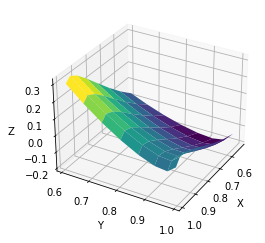

In [9]:
visualize_loss(lambda P, Q: P * np.log(P / Q) + 0.05 * np.log((1 - P) / (1 - Q)))

Running UMAP for neighbors count: [10]
[1]: loss 3209.8971145734645
[50]: loss 1564.4907752318961
[100]: loss 1190.4133885238682
[150]: loss 1189.5756910511145
Running UMAP for neighbors count: [1500]
[1]: loss 710994.9142688535
[50]: loss 404157.84018938284
[100]: loss 391339.1213676602
[150]: loss 386787.85638998146
Running UMAP for neighbors count: [10, 1500]
[1]: loss 397760.4988076191
[50]: loss 238046.1438066429
[100]: loss 224833.02626268295
[150]: loss 224661.5971908003
CPU times: user 9min 24s, sys: 25.9 s, total: 9min 50s
Wall time: 4min 15s


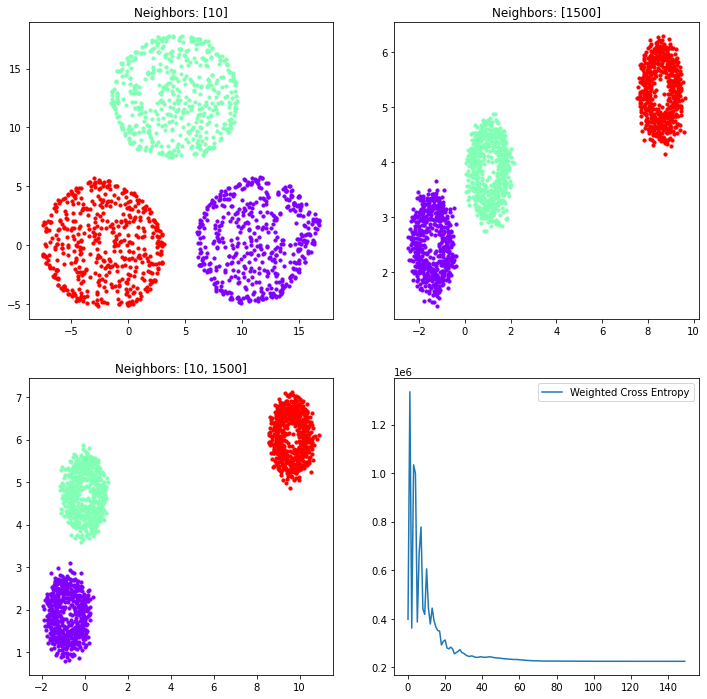

In [10]:
%%time
cel = evaluate_visualizations(
    min_neighbors=MAX_NEIGHBORS,
    max_neighbors=FULL_MAX_NEIGHBORS,
    low_dimension_factory=lambda neighbors: umap(
        pairwise_distances=distances,
        neighbor_counts=neighbors,
        n_components=2,
        min_dist=MIN_DIST,
        optimizer=GradientOptimizer(
            optimizer=Adam(n=len(digits), iterations=ITERATION_LIMIT),
            loss=CrossEntropyLoss(reduce_repulsion=True))))

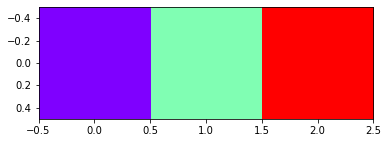

In [11]:
plt.imshow([cm.rainbow(np.linspace(0, 1, max(labels) - min(labels) + 1))])